# Common mushroom genus classification

The objective for this project is to use the mushroom genus image dataset from kaggle to create a mushroom type classifier for the US National Health Service. This classifier would be used in handheld devices to help recognize edible mushroom types for people when picking mushrooms.

In [ ]:
try:
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns
  import os
  from collections import defaultdict
  import splitfolders

  import torch
  import torch.nn as nn
  import torch.optim as optim
  from torch.utils.data import DataLoader, Dataset
  import torchvision
  from torchvision import datasets, models, transforms
  import pytorch_lightning as pl
  import torchmetrics as tm
  
except ImportError:
  !pip install split-folders
  !pip install lightning

  import os
  os.kill(os.getpid(), 9)

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Sat Apr 15 11:43:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
ds_path = "/content/gdrive/MyDrive/Datasets/mushrooms_ds"

To split the dataset into train, validation and test sets, the splitfolders library is used. Split ratios are:
- Train - 70%;
- Validation - 20%;
- Test - 10%;

In [ ]:
splitfolders.ratio("/content/gdrive/MyDrive/Datasets/Mushrooms", 
                   output=ds_path, seed=0, ratio=(.7, .2, .1), 
                   group_prefix=None, move=False)

## EDA

### Creating datasets and dataloaders

To use the data later on with PyTorch Lightning it can be loaded with pytorch dataloaders. Here for training data different random augmentation tranforms can also be applied when loading the data, which will generate more different data samples for model training. Also, there are needed transformations for the resnet model like resize to 224x224 and normalization means and standard deviations for RGB channels.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(ds_path, x),
                                          data_transforms[x]) \
                  for x in ['train', 'val', 'test']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True if x=='train' else False, 
                             num_workers=2) \
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

### Number of samples in classes

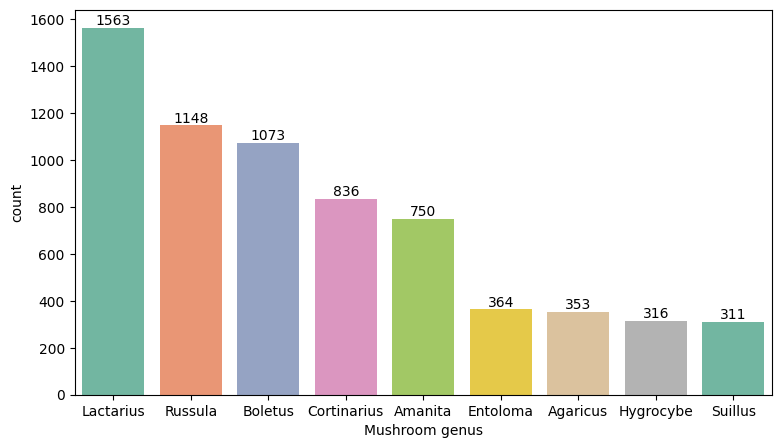

In [ ]:
class_counts = defaultdict(list)

for root_dir, curr_dir, files \
in os.walk("/content/gdrive/MyDrive/Datasets/Mushrooms"):
    root_dir_parts = root_dir.split('/')
    
    if root_dir_parts[-1] in class_names and root_dir_parts[-1] \
    not in class_counts['name']:
        class_counts['name'].append(root_dir_parts[-1])
        class_counts['count'].append(len(files))
        
class_counts_df = pd.DataFrame(class_counts).sort_values('count',
                                                         ascending=False)

plt.figure(figsize=(9,5))
ax = sns.barplot(data=class_counts_df, x='name', y='count', palette='Set2')
ax.set_xlabel('Mushroom genus')
ax.bar_label(ax.containers[0])
plt.show()

We can see that there is an imbalance of number of samples between the 9 mushroom genus classes in the dataset.

### Data sample visualization

In [ ]:
from PIL import Image


img_path = "/content/gdrive/MyDrive/Datasets/Mushrooms/"

n_images = 8

for name in class_names:
  files = os.listdir(os.path.join(img_path, name))
  rand_files = [files[i] for i in np.random.randint(len(files), size=n_images)]

  figure = plt.figure(figsize=(16, 8))
  cols, rows = n_images, 1
  curr_img = 1

  for f in rand_files:
    img = Image.open(os.path.join(img_path, name, f))

    figure.add_subplot(rows, cols, curr_img)
    plt.title(name)
    plt.axis("off")
    plt.imshow(img)

    curr_img += 1

Output hidden; open in https://colab.research.google.com to view.

Just by glancing at the images we can see that, it could be challenging for a human to distinguish some mushrooms. For example, entoloma, lactarius and russula look quite similar. Luckily, transfer learning might help extracting useful features without the huge abundance of data samples.

## Model building with PyTorch Lightning

We will first start with defining the model with PyTorch Lightining module. Then train 3 models with increasing resnet architecture complexity and evaluate their performance on the test set and inference time. 

### Defining the model

In [ ]:
class MushroomClf(pl.LightningModule):
    '''
    Mushroom genus image classifier

    Args:
        class_names (list): List containing class names
        lr (floar, optional): Learning rate
        pt_model (torch.nn.Module, optional): PyTorch model object
        optimizer (optional): PyTorch optimizer class
        resnet_model (optional): torchvision.models resnet model class
        resnet_weights (optional): torchvision.models resnet model weights

    Attributes:
        clf_model: Classifier object
        class_names (list): List containing class names
        num_classes (int): Number of classes
        learning_rate (floar): Learning rate
    '''
    def __init__(self, class_names: list, lr: float=0.001, pt_model=None,
                 optimizer=torch.optim.Adam,
                 resnet_model=torchvision.models.resnet18,
                 resnet_weights=torchvision.models.ResNet18_Weights.DEFAULT):
        super(MushroomClf, self).__init__()

        self.num_classes = len(class_names)
        self.class_names = class_names

        if pt_model is None:
            self.clf_model = resnet_model(weights=resnet_weights)
            
            for param in self.clf_model.parameters():
                param.requires_grad = False

            num_ftrs = self.clf_model.fc.in_features
            self.clf_model.fc = nn.Linear(num_ftrs, self.num_classes)
        else:
            self.clf_model = pt_model

        self.train_auroc = tm.AUROC(task='multiclass', 
                                    num_classes=self.num_classes, 
                                    compute_on_step=False)
        
        self.val_auroc = tm.AUROC(task='multiclass', 
                                  num_classes=self.num_classes, 
                                  compute_on_step=False)
        
        self.test_auroc = tm.AUROC(task='multiclass', 
                                   num_classes=self.num_classes, 
                                   compute_on_step=False)
        
        self.val_cm = tm.ConfusionMatrix(task='multiclass', 
                                         num_classes=self.num_classes, 
                                         compute_on_step=False)
        
        self.test_cm = tm.ConfusionMatrix(task='multiclass', 
                                          num_classes=self.num_classes, 
                                          compute_on_step=False)

        self.learning_rate = lr

        self.first_epoch = True

        self.pt_opt = optimizer
 
    def forward(self, x):
        return self.clf_model(x)

    def _common_step(self, batch):
        x, y = batch
        logit = self.forward(x)
        loss = nn.functional.cross_entropy(logit, y)
        prob_y = nn.functional.softmax(logit)

        return loss, prob_y, y
    
    def training_step(self, batch, batch_idx):
        loss, prob_y, y = self._common_step(batch)
        self.train_auroc.update(prob_y, y)

        self.log_dict({'train/loss': loss, 'train/auroc': self.train_auroc}, 
                      on_epoch=True, on_step=False)

        return loss

    def on_train_epoch_end(self):
        if not self.first_epoch:
            self.train_auroc.reset()

            self.val_cm.reset()
            self.val_auroc.reset()
        else:
            self.first_epoch = False
    
    def validation_step(self, batch, batch_idx):
        loss, prob_y, y = self._common_step(batch)
        self.val_auroc.update(prob_y, y)

        self.log_dict({'val/loss': loss, 'val/auroc': self.val_auroc})

        self.val_cm.update(prob_y, y)

        return loss

    def on_validation_epoch_end(self):
        df_cm = pd.DataFrame(
            self.val_cm.compute().detach().cpu().numpy().astype(int), 
            index=self.class_names, columns=self.class_names)
        
        if self.current_epoch>0 and (self.current_epoch+1)%5==0:
            plt.figure(figsize=(11,4))
            sns.heatmap(df_cm, annot=True, cmap='magma', fmt='')
            plt.title(f'Confusion Matrix (Epoch {self.current_epoch+1})')
            plt.show()

    def test_step(self, batch, batch_idx):
        loss, prob_y, y = self._common_step(batch)
        self.test_auroc.update(prob_y, y)

        self.log_dict({'test/loss': loss, 'test/auroc': self.test_auroc})

        self.test_cm.update(prob_y, y)

        return loss

    def on_test_epoch_end(self):
        df_cm = pd.DataFrame(
            self.test_cm.compute().detach().cpu().numpy().astype(int), 
            index=self.class_names, columns=self.class_names)
        
        plt.figure(figsize=(11,4))
        sns.heatmap(df_cm, annot=True, cmap='magma', fmt='')
        plt.show()

    def configure_optimizers(self):
        return self.pt_opt(self.parameters(), lr=self.learning_rate)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs/mushroom_clf_logs/

### Training

#### Resnet18 backbone

In [ ]:
VERSION = 'resnet18'

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                      | Params
-----------------------------------------------------------
0 | resnet_model | ResNet                    | 11.2 M
1 | train_auroc  | MulticlassAUROC           | 0     
2 | val_auroc    | MulticlassAUROC           | 0     
3 | test_auroc   | MulticlassAUROC           | 0     
4 | val_cm       | MulticlassC

Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

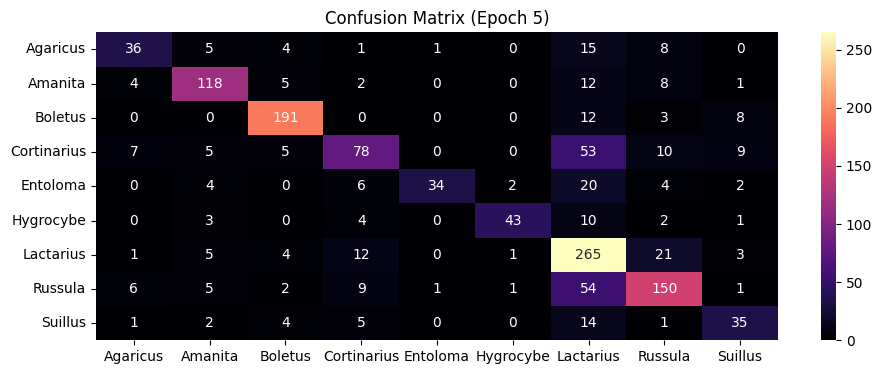

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

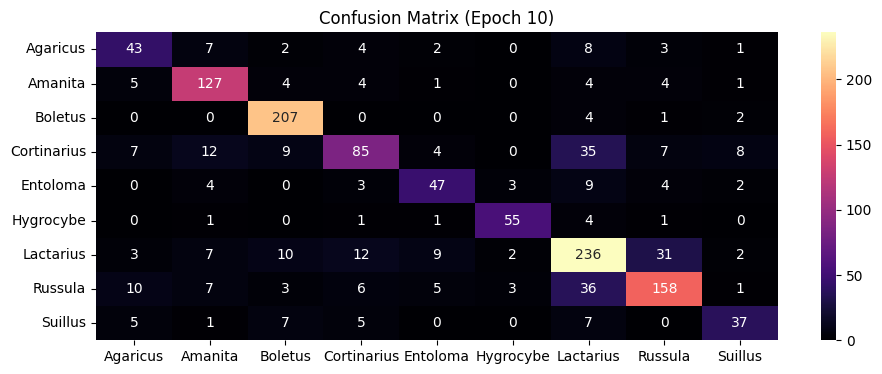

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

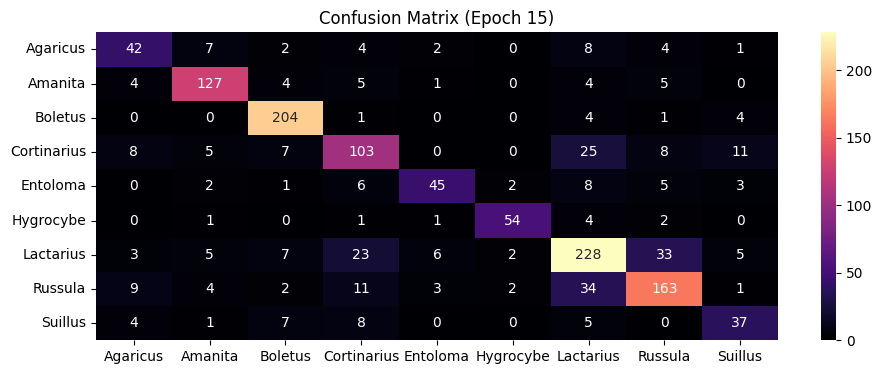

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

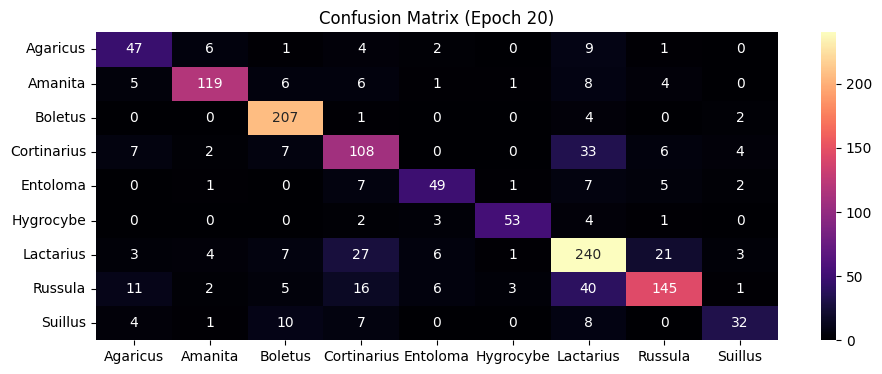

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

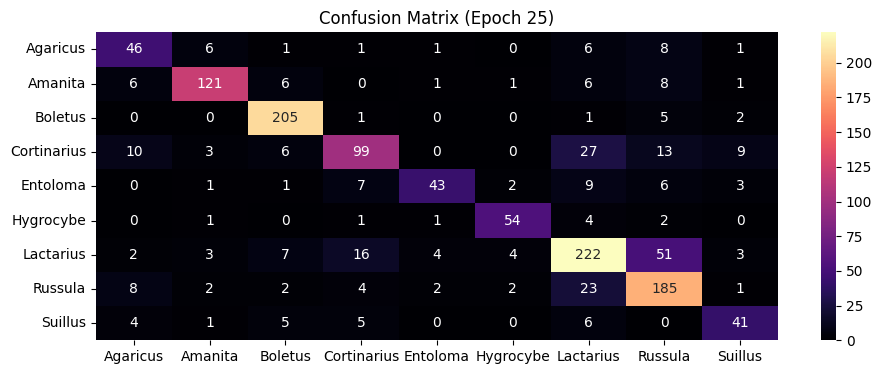

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

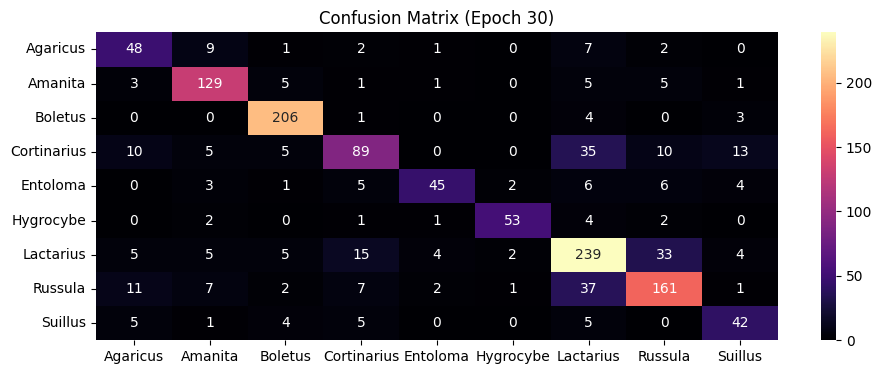

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
model = MushroomClf(class_names)

tb_logger = pl.loggers.TensorBoardLogger(save_dir='logs', 
                                         name='mushroom_clf_logs',
                                         version=VERSION)

csv_logger = pl.loggers.CSVLogger(save_dir='logs', 
                                  name='mushroom_clf_logs',
                                  version=VERSION)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'logs/mushroom_clf_logs/{VERSION}/best_ckpt',
    filename='mush-genus-epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False,
    monitor='val/loss'
)

trainer = pl.Trainer(max_epochs=30, logger=[tb_logger, csv_logger], 
                     callbacks=[checkpoint_callback])

trainer.fit(model, train_dataloaders=dataloaders['train'], 
            val_dataloaders=dataloaders['val'])

In [ ]:
def plot_metrics(path: str) -> None:
  fig, ax = plt.subplots(1, 2, figsize=(10,4))

  df = pd.read_csv(path)
  df = df.set_index('epoch')

  sns.lineplot(data=df[['train/loss', 'val/loss']], ax=ax[0])
  ax[0].set_ylabel('loss')
  sns.lineplot(data=df[['train/auroc', 'val/auroc']], ax=ax[1])
  ax[1].set_ylabel('auroc')

  plt.show()

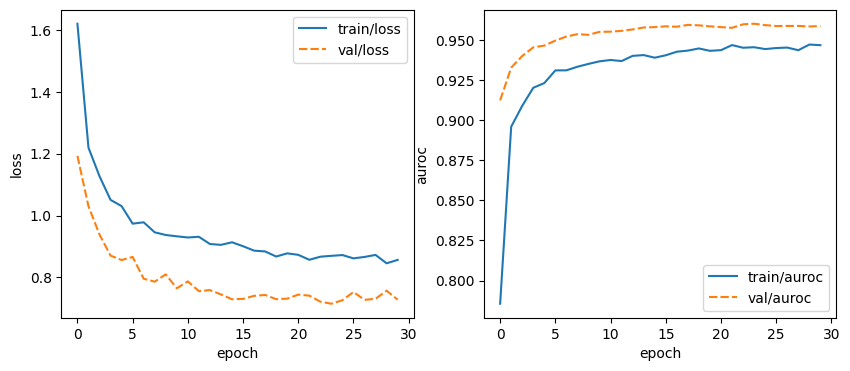

In [ ]:
plot_metrics(f'logs/mushroom_clf_logs/{VERSION}/metrics.csv')

#### Resnet34 backbone

In [ ]:
VERSION = 'resnet34'

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 75.1MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                      | Params
-----------------------------------------------------------
0 | resnet_model | ResNet                    | 21.3 M
1 | train_auroc  | MulticlassAUROC           | 0     
2 | val_auroc    | MulticlassAUROC           | 0     
3 | test_auroc   | MulticlassAUROC           | 0     
4 | val_cm       | Multiclass

Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

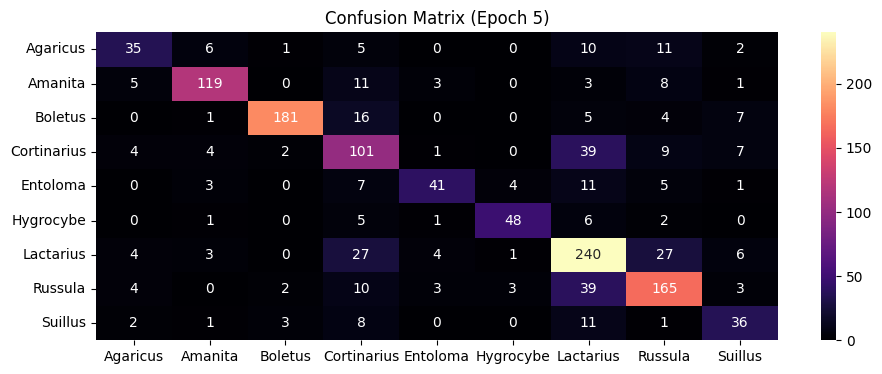

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

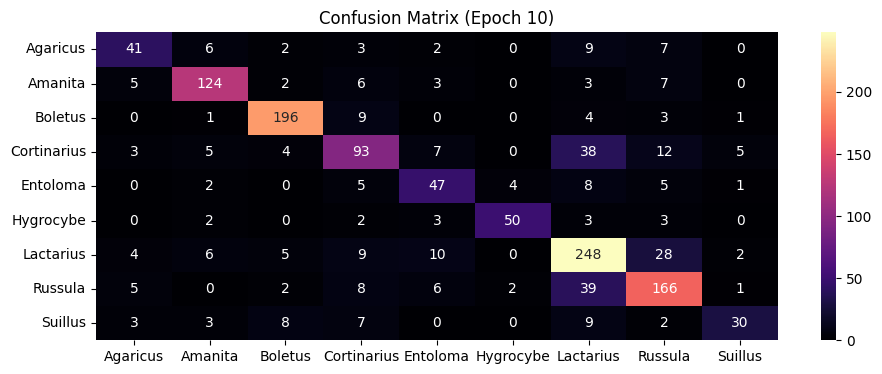

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

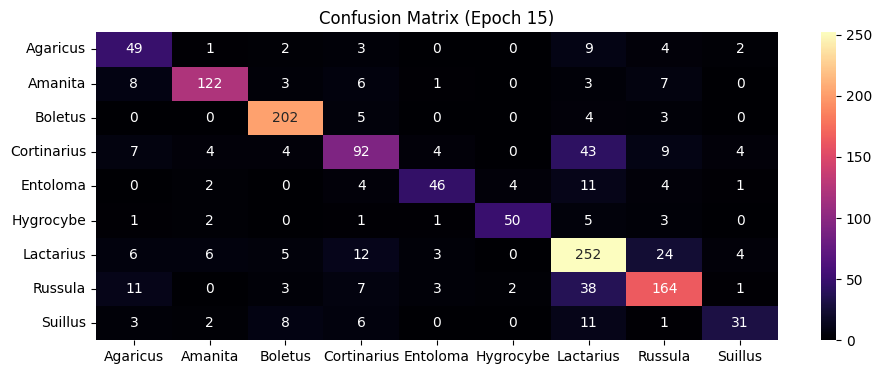

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

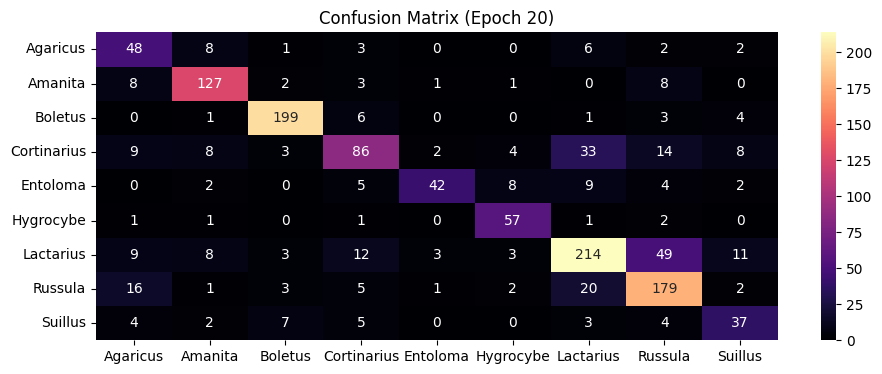

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

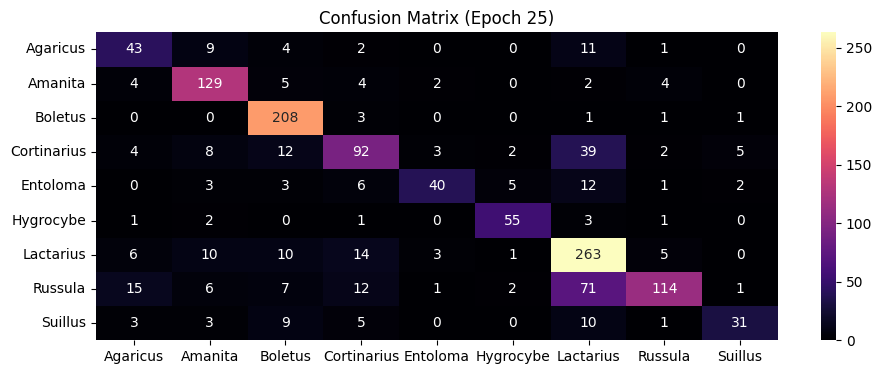

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

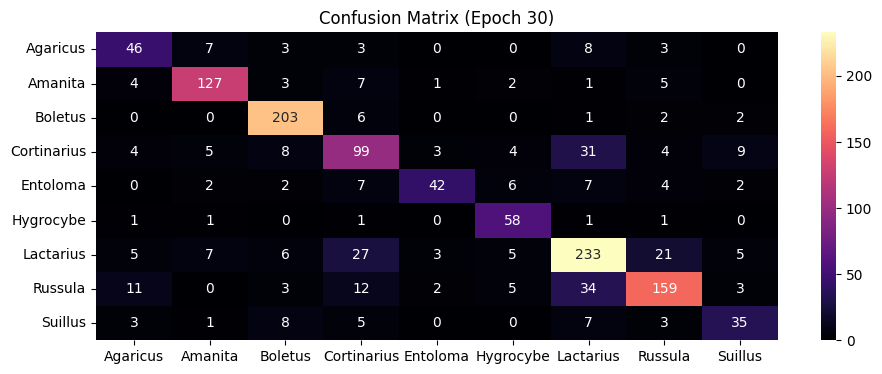

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
model = MushroomClf(class_names, resnet_model=torchvision.models.resnet34,
                    resnet_weights=torchvision.models.ResNet34_Weights.DEFAULT)

tb_logger = pl.loggers.TensorBoardLogger(save_dir='logs', 
                                         name='mushroom_clf_logs',
                                         version=VERSION)

csv_logger = pl.loggers.CSVLogger(save_dir='logs', 
                                  name='mushroom_clf_logs',
                                  version=VERSION)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'logs/mushroom_clf_logs/{VERSION}/best_ckpt',
    filename='mush-genus-epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False,
    monitor='val/loss'
)

trainer = pl.Trainer(max_epochs=30, logger=[tb_logger, csv_logger], 
                     callbacks=[checkpoint_callback])

trainer.fit(model, train_dataloaders=dataloaders['train'], 
            val_dataloaders=dataloaders['val'])

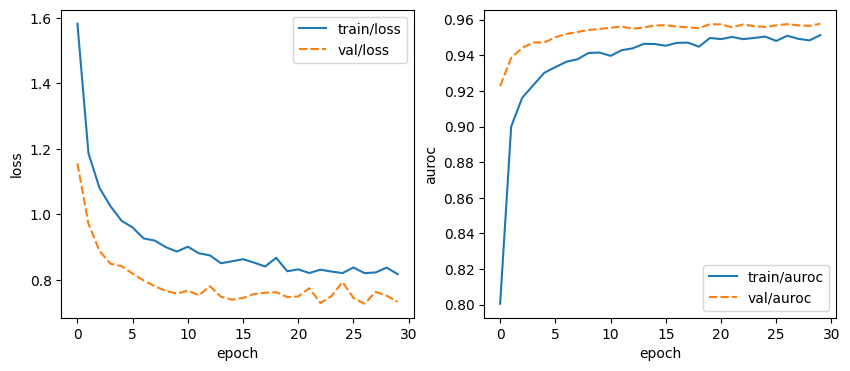

In [ ]:
plot_metrics(f'logs/mushroom_clf_logs/{VERSION}/metrics.csv')

#### Resnet50 backbone

In [ ]:
VERSION = 'resnet50'

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.5MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type                      | Params
-----------------------------------------------------------
0 | resnet_model | ResNet                    | 23.5 M
1 | train_auroc  | MulticlassAUROC           | 0     
2 | val_auroc    | MulticlassAUROC           | 0     
3 | test_auroc   | MulticlassAUROC           | 0     
4 | val_cm       | Multiclass

Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

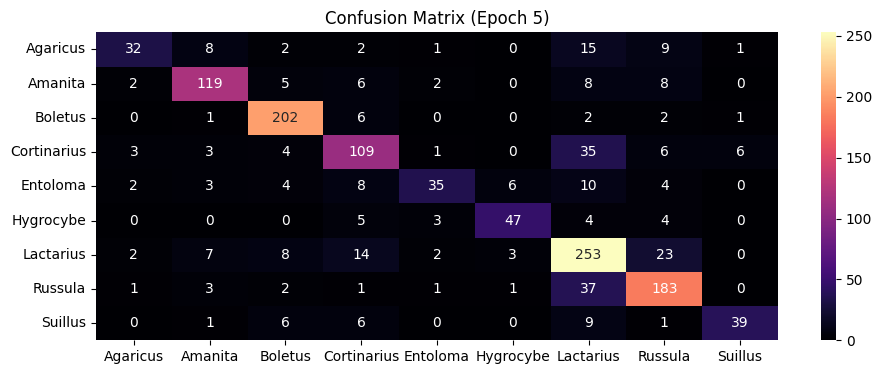

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

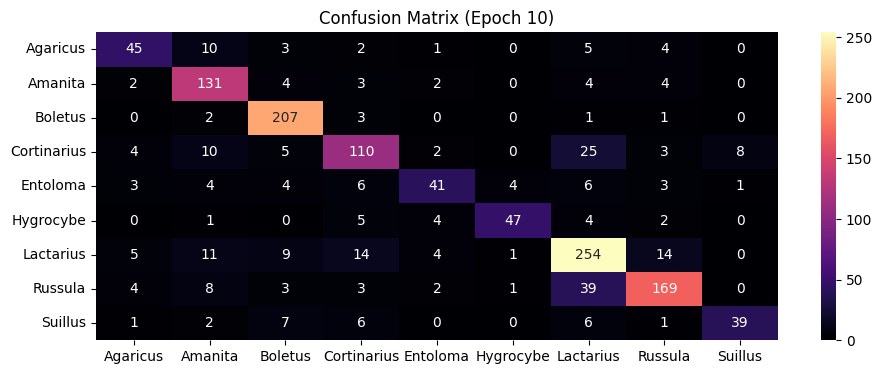

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

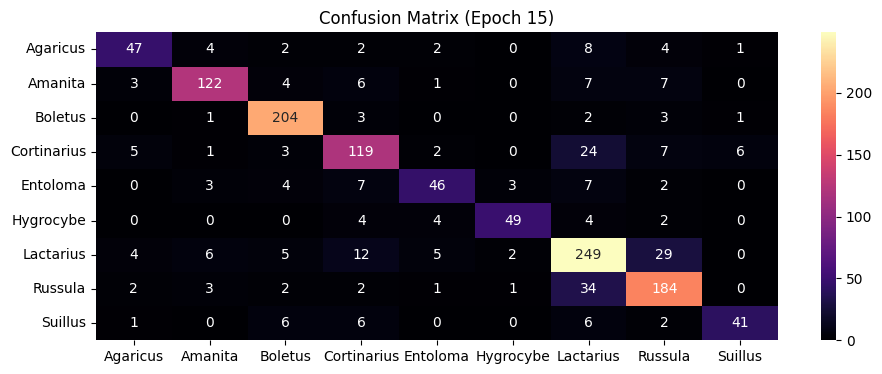

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

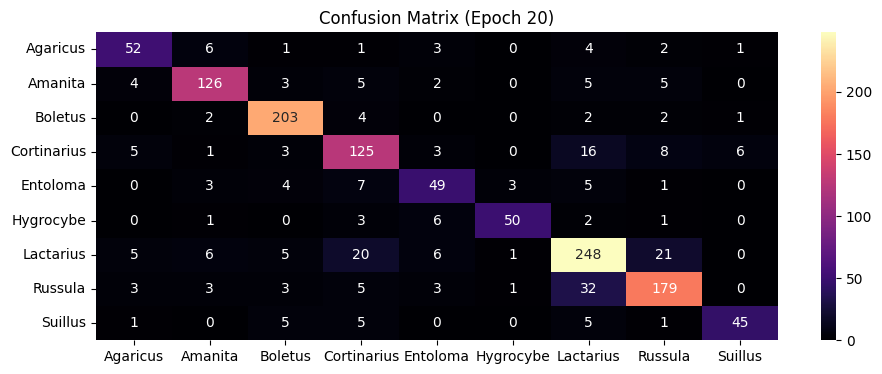

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

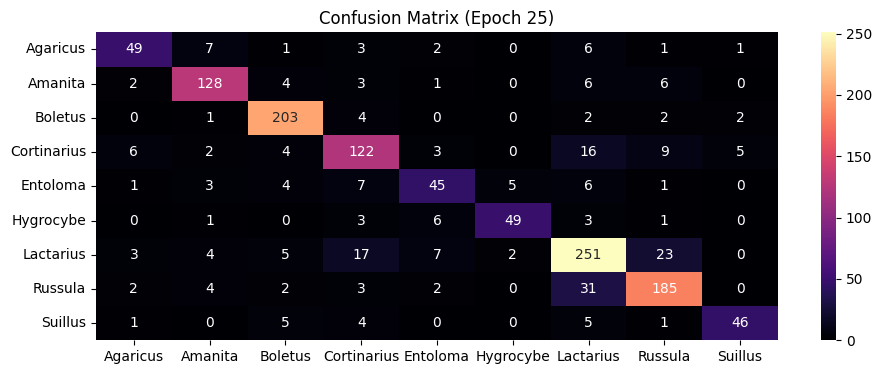

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

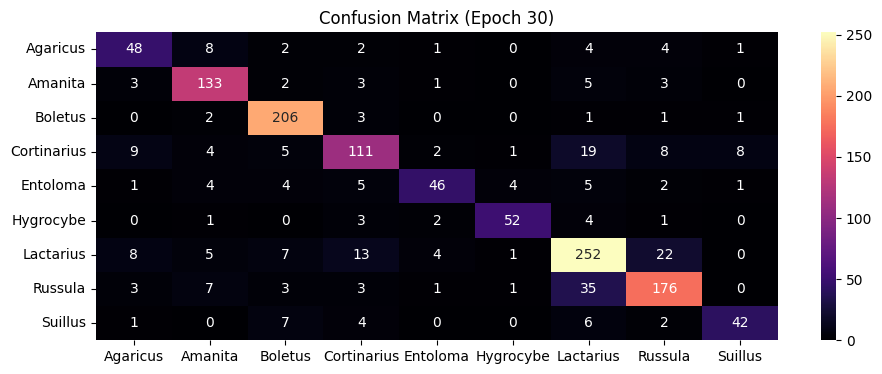

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
model = MushroomClf(class_names, resnet_model=torchvision.models.resnet50,
                    resnet_weights=torchvision.models.ResNet50_Weights.DEFAULT)

tb_logger = pl.loggers.TensorBoardLogger(save_dir='logs', 
                                         name='mushroom_clf_logs',
                                         version=VERSION)

csv_logger = pl.loggers.CSVLogger(save_dir='logs', 
                                  name='mushroom_clf_logs',
                                  version=VERSION)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'logs/mushroom_clf_logs/{VERSION}/best_ckpt',
    filename='mush-genus-epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False,
    monitor='val/loss'
)

trainer = pl.Trainer(max_epochs=30, logger=[tb_logger, csv_logger], 
                     callbacks=[checkpoint_callback])

trainer.fit(model, train_dataloaders=dataloaders['train'], 
            val_dataloaders=dataloaders['val'])

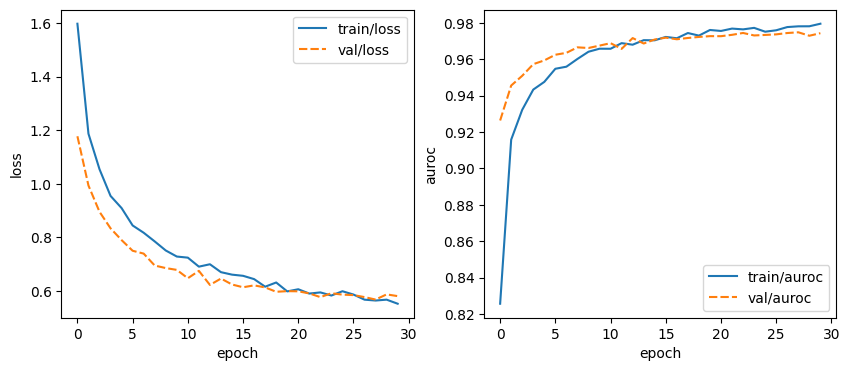

In [ ]:
plot_metrics(f'logs/mushroom_clf_logs/{VERSION}/metrics.csv')

### Evaluation

#### Resnet18 backbone

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/logs/mushroom_clf_logs/resnet18/best_ckpt/mush-genus-epoch23-val_loss0.72.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/logs/mushroom_clf_logs/resnet18/best_ckpt/mush-genus-epoch23-val_loss0.72.ckpt


Testing: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


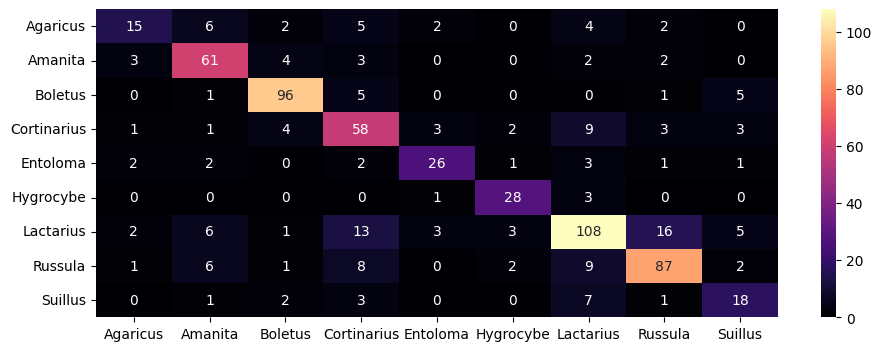

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/auroc         │    0.9629439115524292     │
│         test/loss         │    0.7193465232849121     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.7193465232849121, 'test/auroc': 0.9629439115524292}]

In [ ]:
model = MushroomClf(class_names, resnet_model=torchvision.models.resnet18,
                    resnet_weights=torchvision.models.ResNet18_Weights.DEFAULT)

trainer = pl.Trainer()

ckpt_path='logs/mushroom_clf_logs/resnet18/best_ckpt/mush-genus-epoch23-val_loss0.72.ckpt'

trainer.test(model, dataloaders['test'], ckpt_path=ckpt_path)

In [ ]:
trainer = pl.Trainer(profiler='pytorch')

%time _ = trainer.predict(model, dataloaders['test'], ckpt_path=ckpt_path)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/mushroom_clf_logs/resnet18/best_ckpt/mush-genus-epoch23-val_loss0.72.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/mushroom_clf_logs/resnet18/best_ckpt/mush-genus-epoch23-val_loss0.72.ckpt


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.profilers.profiler:PREDICT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.97%      15.337ms        98.45%        1.558s     519.265ms       0.000us         0.00%     130.541ms      43.514ms             3  
            [pl][profile][_PredictionLoop].predict_next         0.02%     331.000us        89.14%        1.410s   

CPU times: user 1.05 s, sys: 314 ms, total: 1.36 s
Wall time: 11.5 s


#### Resnet34 backbone

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/mushroom_clf_logs/resnet34/best_ckpt/mush-genus-epoch26-val_loss0.73.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/mushroom_clf_logs/resnet34/best_ckpt/mush-genus-epoch26-val_loss0.73.ckpt


Testing: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


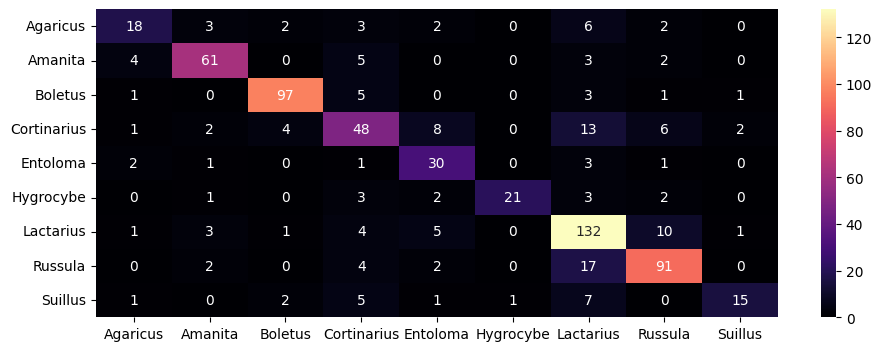

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/auroc         │    0.9659996032714844     │
│         test/loss         │     0.694989800453186     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.694989800453186, 'test/auroc': 0.9659996032714844}]

In [ ]:
model = MushroomClf(class_names, resnet_model=torchvision.models.resnet34,
                    resnet_weights=torchvision.models.ResNet34_Weights.DEFAULT)

trainer = pl.Trainer()

ckpt_path='logs/mushroom_clf_logs/resnet34/best_ckpt/mush-genus-epoch26-val_loss0.73.ckpt'

trainer.test(model, dataloaders['test'], ckpt_path=ckpt_path)

In [ ]:
trainer = pl.Trainer(profiler='pytorch')

%time _ = trainer.predict(model, dataloaders['test'], ckpt_path=ckpt_path)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/mushroom_clf_logs/resnet34/best_ckpt/mush-genus-epoch26-val_loss0.73.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/mushroom_clf_logs/resnet34/best_ckpt/mush-genus-epoch26-val_loss0.73.ckpt


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.profilers.profiler:PREDICT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         1.12%      26.723ms        99.91%        2.391s     797.028ms       0.000us         0.00%     207.408ms      69.136ms             3  
            [pl][profile][_PredictionLoop].predict_next         0.01%     245.000us        86.82%        2.078s   

CPU times: user 1.59 s, sys: 371 ms, total: 1.96 s
Wall time: 12.6 s


#### Resnet50 backbone

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/mushroom_clf_logs/resnet50/best_ckpt/mush-genus-epoch27-val_loss0.57.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/mushroom_clf_logs/resnet50/best_ckpt/mush-genus-epoch27-val_loss0.57.ckpt


Testing: 0it [00:00, ?it/s]

<ipython-input-7-ff1124d75716>:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


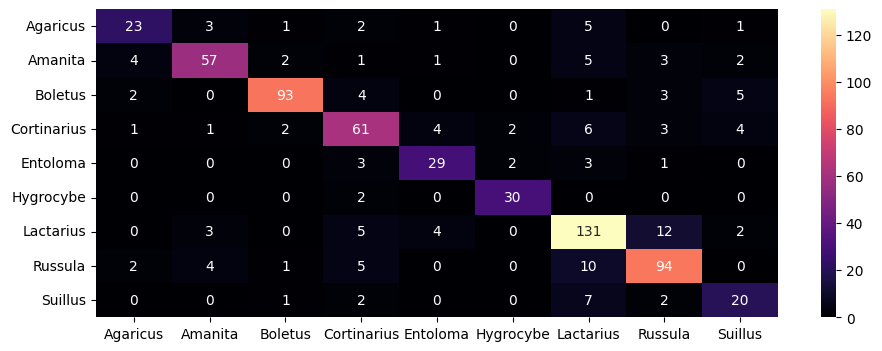

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/auroc         │    0.9778919219970703     │
│         test/loss         │    0.5745341181755066     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.5745341181755066, 'test/auroc': 0.9778919219970703}]

In [ ]:
model = MushroomClf(class_names, resnet_model=torchvision.models.resnet50,
                    resnet_weights=torchvision.models.ResNet50_Weights.DEFAULT)

trainer = pl.Trainer()

ckpt_path='logs/mushroom_clf_logs/resnet50/best_ckpt/mush-genus-epoch27-val_loss0.57.ckpt'

trainer.test(model, dataloaders['test'], ckpt_path=ckpt_path)

In [ ]:
trainer = pl.Trainer(profiler='pytorch')

%time _ = trainer.predict(model, dataloaders['test'], ckpt_path=ckpt_path)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/mushroom_clf_logs/resnet50/best_ckpt/mush-genus-epoch27-val_loss0.57.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/mushroom_clf_logs/resnet50/best_ckpt/mush-genus-epoch27-val_loss0.57.ckpt


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.profilers.profiler:PREDICT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         1.38%      39.165ms        99.50%        2.815s     938.363ms       0.000us         0.00%     295.569ms      98.523ms             3  
            [pl][profile][_PredictionLoop].predict_next         0.01%     286.000us        85.05%        2.406s   

CPU times: user 2.38 s, sys: 387 ms, total: 2.77 s
Wall time: 12.8 s


In [ ]:
#!zip -r /content/gdrive/MyDrive/mushroom_clf_logs.zip logs/mushroom_clf_logs/

In [ ]:
#!unzip /content/gdrive/MyDrive/mushroom_clf_logs.zip -d ./

## Project results

Here are the training results:
- As seen from the test metrics, model with resnet50 performs the best with AUROC - 0.978 and loss - 0.575;
- Model with resnet50 also has the best classification quality as seen from the confusion matrix. The most common errors accross all models are classifying between lactarius and russula, and between lactarius and cortinarius. This is because these mushrooms are similar visualy, as seen previously from sample images. These errors can be reduced by adding more samples to these classes or using even deeper backbone, which would increase inference time significantly.
- Model with the lowest inference time is with resnet18, but comparing to other models it performs the worst.

## Bonus challenges

### Different optimizer

#### Training

In [ ]:
VERSION = 'adagrad'

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                      | Params
----------------------------------------------------------
0 | clf_model   | ResNet                    | 23.5 M
1 | train_auroc | MulticlassAUROC           | 0     
2 | val_auroc   | MulticlassAUROC           | 0     
3 | test_auroc  | MulticlassAUROC           | 0     
4 | val_cm      | MulticlassConfusionMatrix | 0     
5 | test_cm     | MulticlassConfusionMatrix | 0     
----------------------------------------------------------
18.4 K    Trainable params
23.5 M    Non-trainable param

Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

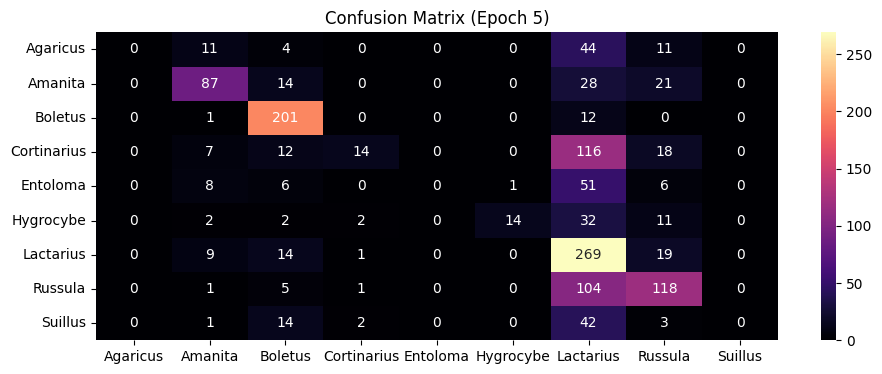

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

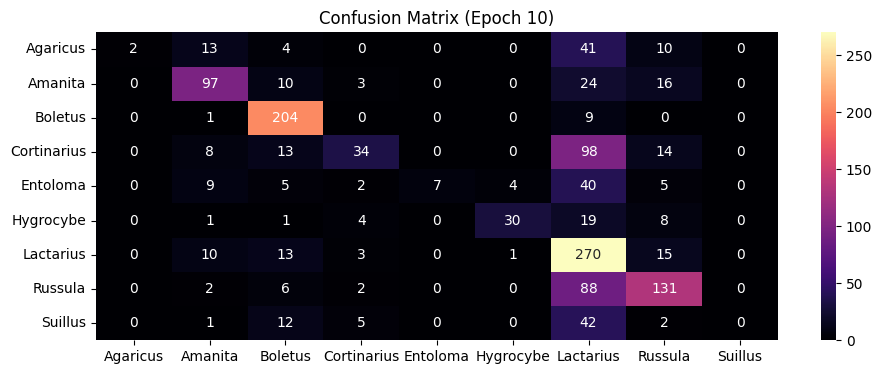

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

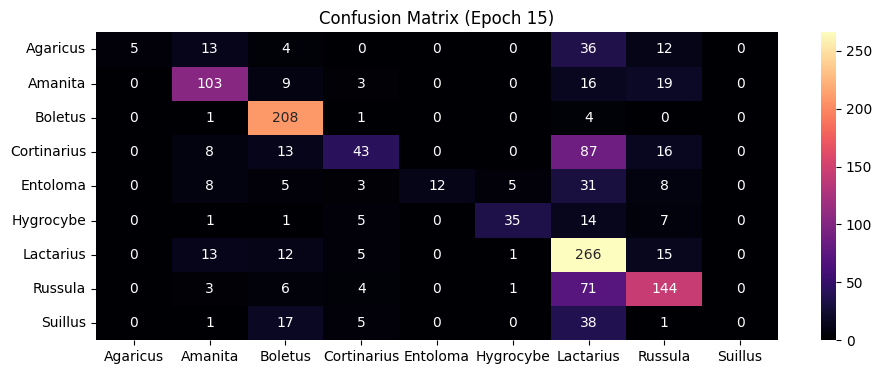

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

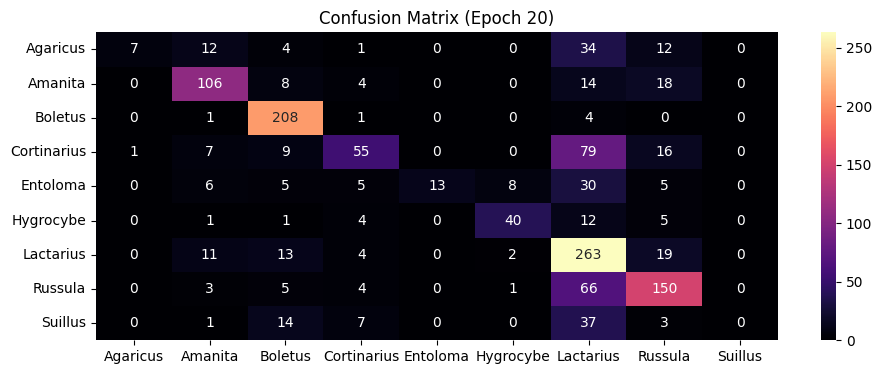

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

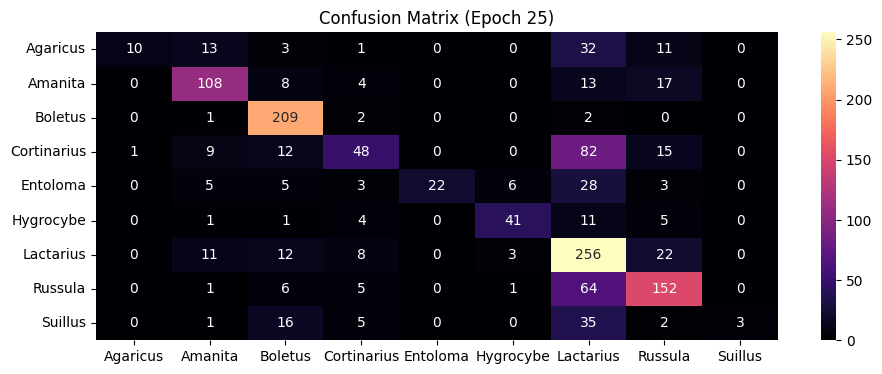

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

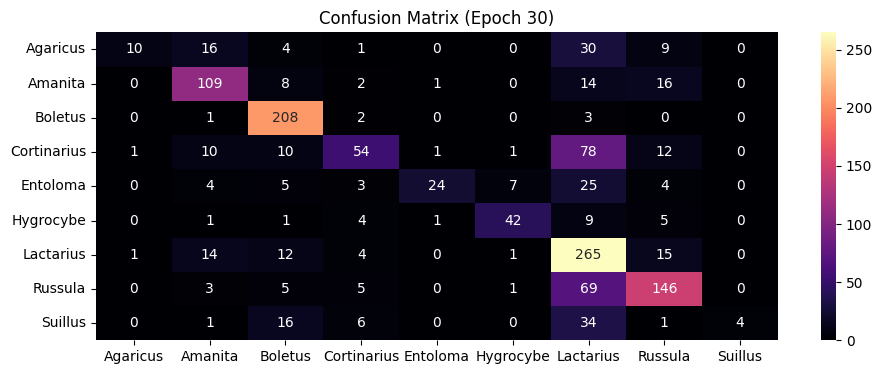

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
model = MushroomClf(class_names, optimizer=torch.optim.Adagrad, 
                    resnet_model=torchvision.models.resnet50,
                    resnet_weights=torchvision.models.ResNet50_Weights.DEFAULT)

tb_logger = pl.loggers.TensorBoardLogger(save_dir='logs', 
                                         name='mushroom_clf_logs',
                                         version=VERSION)

csv_logger = pl.loggers.CSVLogger(save_dir='logs', 
                                  name='mushroom_clf_logs',
                                  version=VERSION)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'logs/mushroom_clf_logs/{VERSION}/best_ckpt',
    filename='mush-genus-epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False,
    monitor='val/loss'
)

trainer = pl.Trainer(max_epochs=30, logger=[tb_logger, csv_logger], 
                     callbacks=[checkpoint_callback])

trainer.fit(model, train_dataloaders=dataloaders['train'], 
            val_dataloaders=dataloaders['val'])

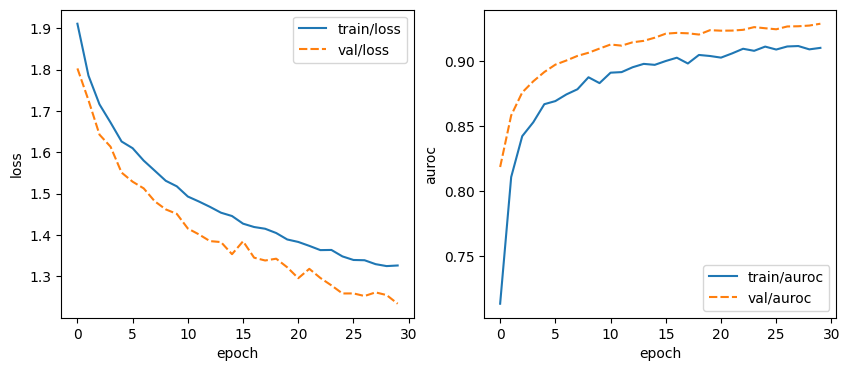

In [ ]:
plot_metrics(f'logs/mushroom_clf_logs/{VERSION}/metrics.csv')

#### Evaluation

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/logs/mushroom_clf_logs/adagrad/best_ckpt/mush-genus-epoch29-val_loss1.23.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/logs/mushroom_clf_logs/adagrad/best_ckpt/mush-genus-epoch29-val_loss1.23.ckpt


Testing: 0it [00:00, ?it/s]

<ipython-input-6-5708547fe2da>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


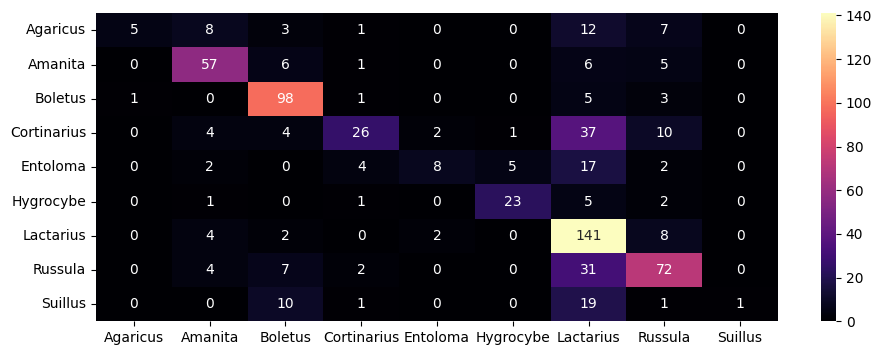

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/auroc         │    0.9345222115516663     │
│         test/loss         │    1.2440003156661987     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 1.2440003156661987, 'test/auroc': 0.9345222115516663}]

In [ ]:
model = MushroomClf(class_names, optimizer=torch.optim.Adagrad, 
                    resnet_model=torchvision.models.resnet50,
                    resnet_weights=torchvision.models.ResNet50_Weights.DEFAULT)

trainer = pl.Trainer()

ckpt_path='/content/logs/mushroom_clf_logs/adagrad/best_ckpt/mush-genus-epoch29-val_loss1.23.ckpt'

trainer.test(model, dataloaders['test'], ckpt_path=ckpt_path)

We can see that the results are worse with resnet50 backbone, after training for same amount of 30 epochs with Adagrad optimizer.

### Intermediate layer between the backbone and output layer

We can try adding an extra layer between the resnet backbone and an output layer to see if better performance can be achieved. For this a pytorch model will be defined.

In [ ]:
class PTModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.clf_model = torchvision.models.resnet50(
            weights=torchvision.models.ResNet50_Weights.DEFAULT)
            
        for param in self.clf_model.parameters():
            param.requires_grad = False

        num_ftrs = self.clf_model.fc.in_features

        self.clf_model.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.clf_model(x)

#### Training

In [ ]:
VERSION = 'extra_layers'

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                      | Params
----------------------------------------------------------
0 | clf_model   | PTModel                   | 24.0 M
1 | train_auroc | MulticlassAUROC           | 0     
2 | val_auroc   | MulticlassAUROC           | 0     
3 | test_auroc  | MulticlassAUROC           | 0     
4 | val_cm      | MulticlassConfusionMatrix | 0     
5 | test_cm     | MulticlassConfusionMatrix | 0     
----------------------------------------------------------
526 K     Trainable params
23.5 M    Non-trainable param

Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

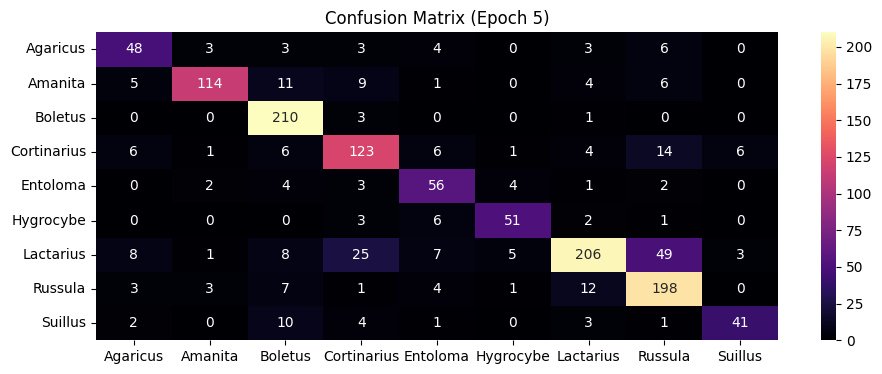

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

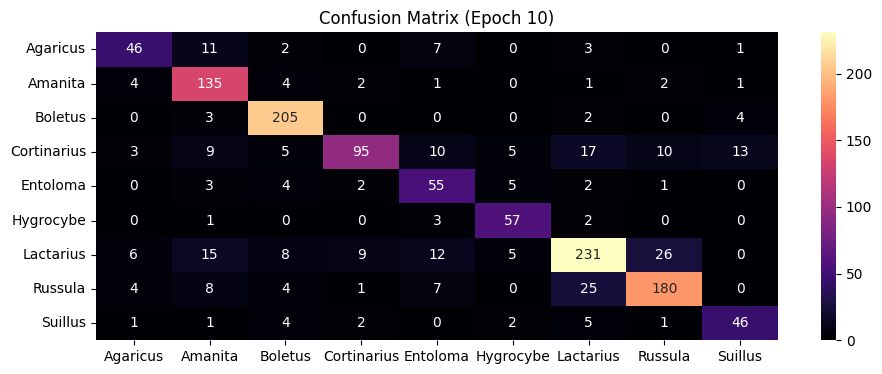

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

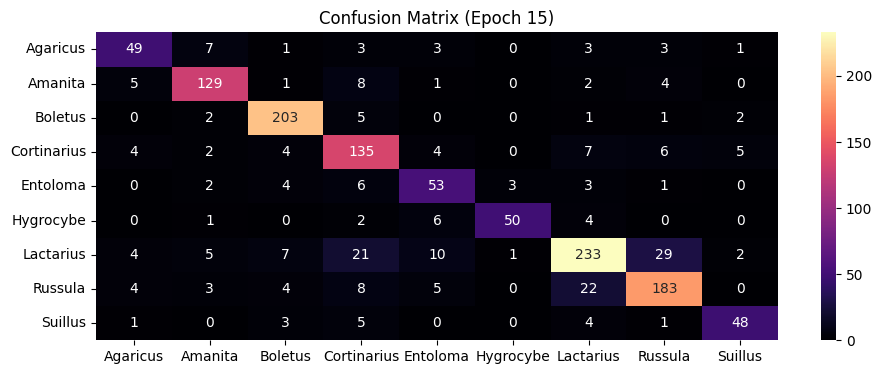

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

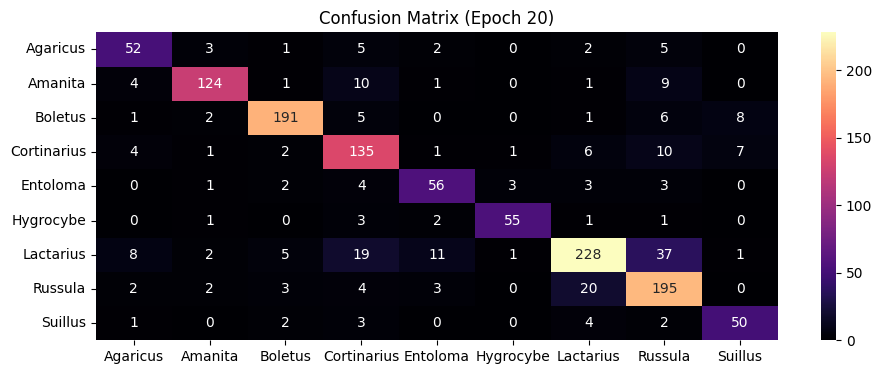

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

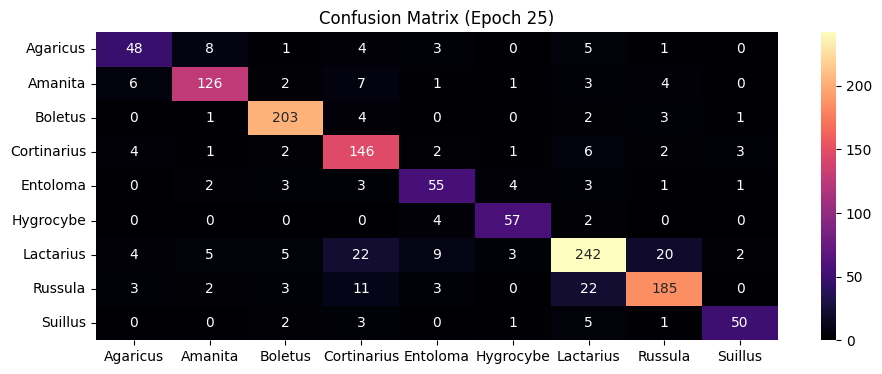

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

<ipython-input-30-4057197c5264>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


Validation: 0it [00:00, ?it/s]

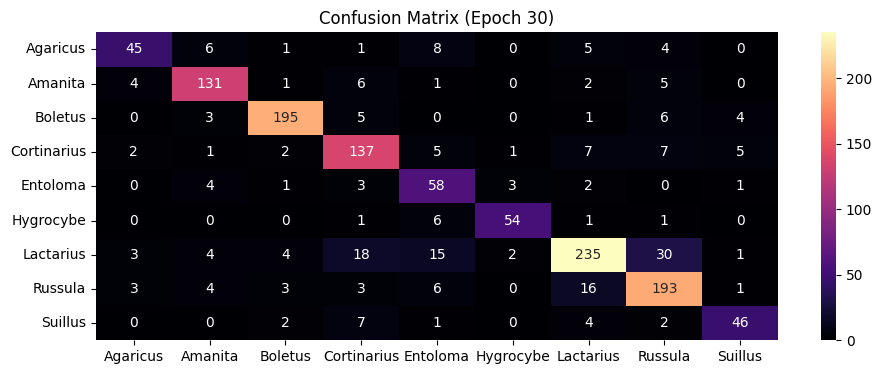

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
model = MushroomClf(class_names, pt_model=PTModel(len(class_names)))

tb_logger = pl.loggers.TensorBoardLogger(save_dir='logs', 
                                         name='mushroom_clf_logs',
                                         version=VERSION)

csv_logger = pl.loggers.CSVLogger(save_dir='logs', 
                                  name='mushroom_clf_logs',
                                  version=VERSION)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f'logs/mushroom_clf_logs/{VERSION}/best_ckpt',
    filename='mush-genus-epoch{epoch:02d}-val_loss{val/loss:.2f}',
    auto_insert_metric_name=False,
    monitor='val/loss'
)

trainer = pl.Trainer(max_epochs=30, logger=[tb_logger, csv_logger], 
                     callbacks=[checkpoint_callback])

trainer.fit(model, train_dataloaders=dataloaders['train'], 
            val_dataloaders=dataloaders['val'])

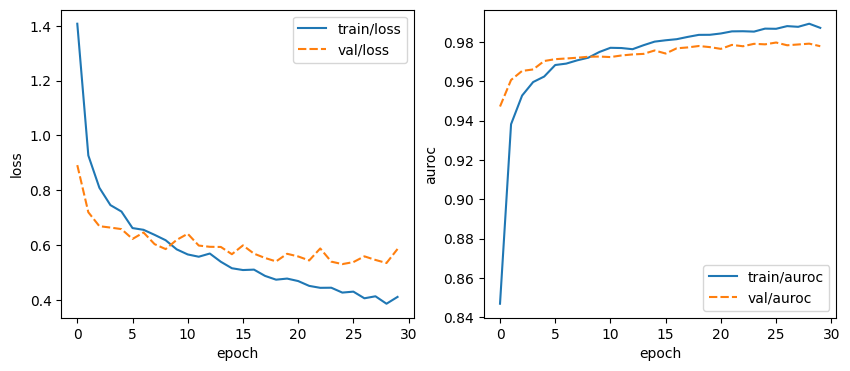

In [ ]:
plot_metrics(f'logs/mushroom_clf_logs/{VERSION}/metrics.csv')

#### Evaluation

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/logs/mushroom_clf_logs/extra_layers/best_ckpt/mush-genus-epoch24-val_loss0.53.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/logs/mushroom_clf_logs/extra_layers/best_ckpt/mush-genus-epoch24-val_loss0.53.ckpt


Testing: 0it [00:00, ?it/s]

<ipython-input-6-5708547fe2da>:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_y = nn.functional.softmax(logit)


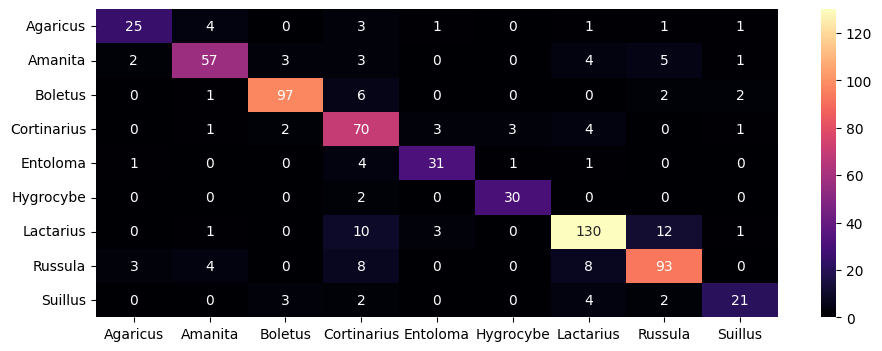

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/auroc         │    0.9809399843215942     │
│         test/loss         │    0.5372257232666016     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.5372257232666016, 'test/auroc': 0.9809399843215942}]

In [ ]:
model = MushroomClf(class_names, pt_model=PTModel(len(class_names)))

trainer = pl.Trainer()

ckpt_path='/content/logs/mushroom_clf_logs/extra_layers/best_ckpt/mush-genus-epoch24-val_loss0.53.ckpt'

trainer.test(model, dataloaders['test'], ckpt_path=ckpt_path)

In [ ]:
trainer = pl.Trainer(profiler='pytorch')

%time _ = trainer.predict(model, dataloaders['test'], ckpt_path=ckpt_path)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/logs/mushroom_clf_logs/extra_layers/best_ckpt/mush-genus-epoch24-val_loss0.53.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/logs/mushroom_clf_logs/extra_layers/best_ckpt/mush-genus-epoch24-val_loss0.53.ckpt


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.profilers.profiler:PREDICT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.97%      15.069ms        98.06%        1.523s     507.532ms       0.000us         0.00%     275.117ms      91.706ms             3  
            [pl][profile][_PredictionLoop].predict_next         0.03%     444.000us        74.69%        1.160s   

CPU times: user 2.51 s, sys: 382 ms, total: 2.9 s
Wall time: 11.1 s


With an extra layer between resnet50 and output layer we get a better performing model, because the loss is lower and auroc is higher on the test set.